# No U Turn MCMC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
import pints.cptests.no_u_turn_mcmc as nuts

from utils import run_replicates, ecdf_norm_plotter

parallel = True

# Two dimensional Gaussian

In [2]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.two_dim_gaussian, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_2d_gaussian.csv")

37.87 seconds


/Users/ioaros/opt/anaconda3/envs/pints/lib/python3.8/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


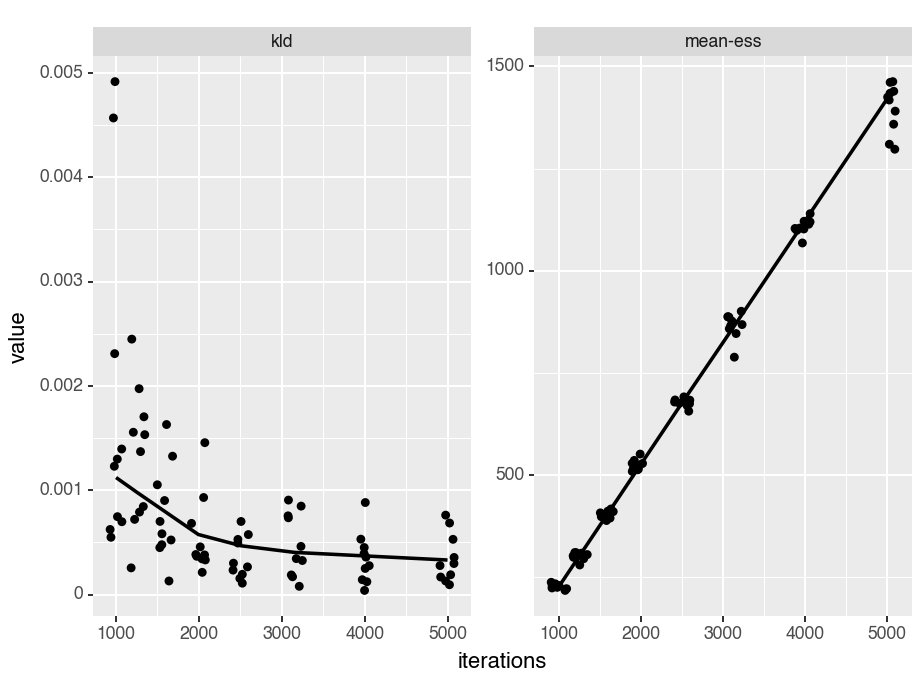

<Figure Size: (460 x 345)>

In [3]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The ESS and KLD both trend in the correct directions.

Show example run results.

Using No-U-Turn MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     44     0.333    1       0.333    1       0.126    2       0.333    1        0:00.0
1     48     0.25     1       0.25     1       0.25     1       0.25     1        0:00.0
2     52     0.25     1                        0.25     1       0.25     1        0:00.0
3     64     0.5      1       0.167    1       0.5      2       0.5      2        0:00.0
20    292    0.766    3       0.776    4       0.758    3       0.749    2        0:00.0
40    500    0.755    3       0.745    3       0.767    3       0.773    3        0:00.0
60    684    0.758    3       0.756    3       0.759    3       0.750035 2        0:00.1
80    844    0.765    3       0.753    2       0.755    2       0.752    3        0:00.1
100   1004   0.681742 2       0.749    2       0.664    3       0.696    3        0:00.1
120   1248   0.778    3       0.726    3

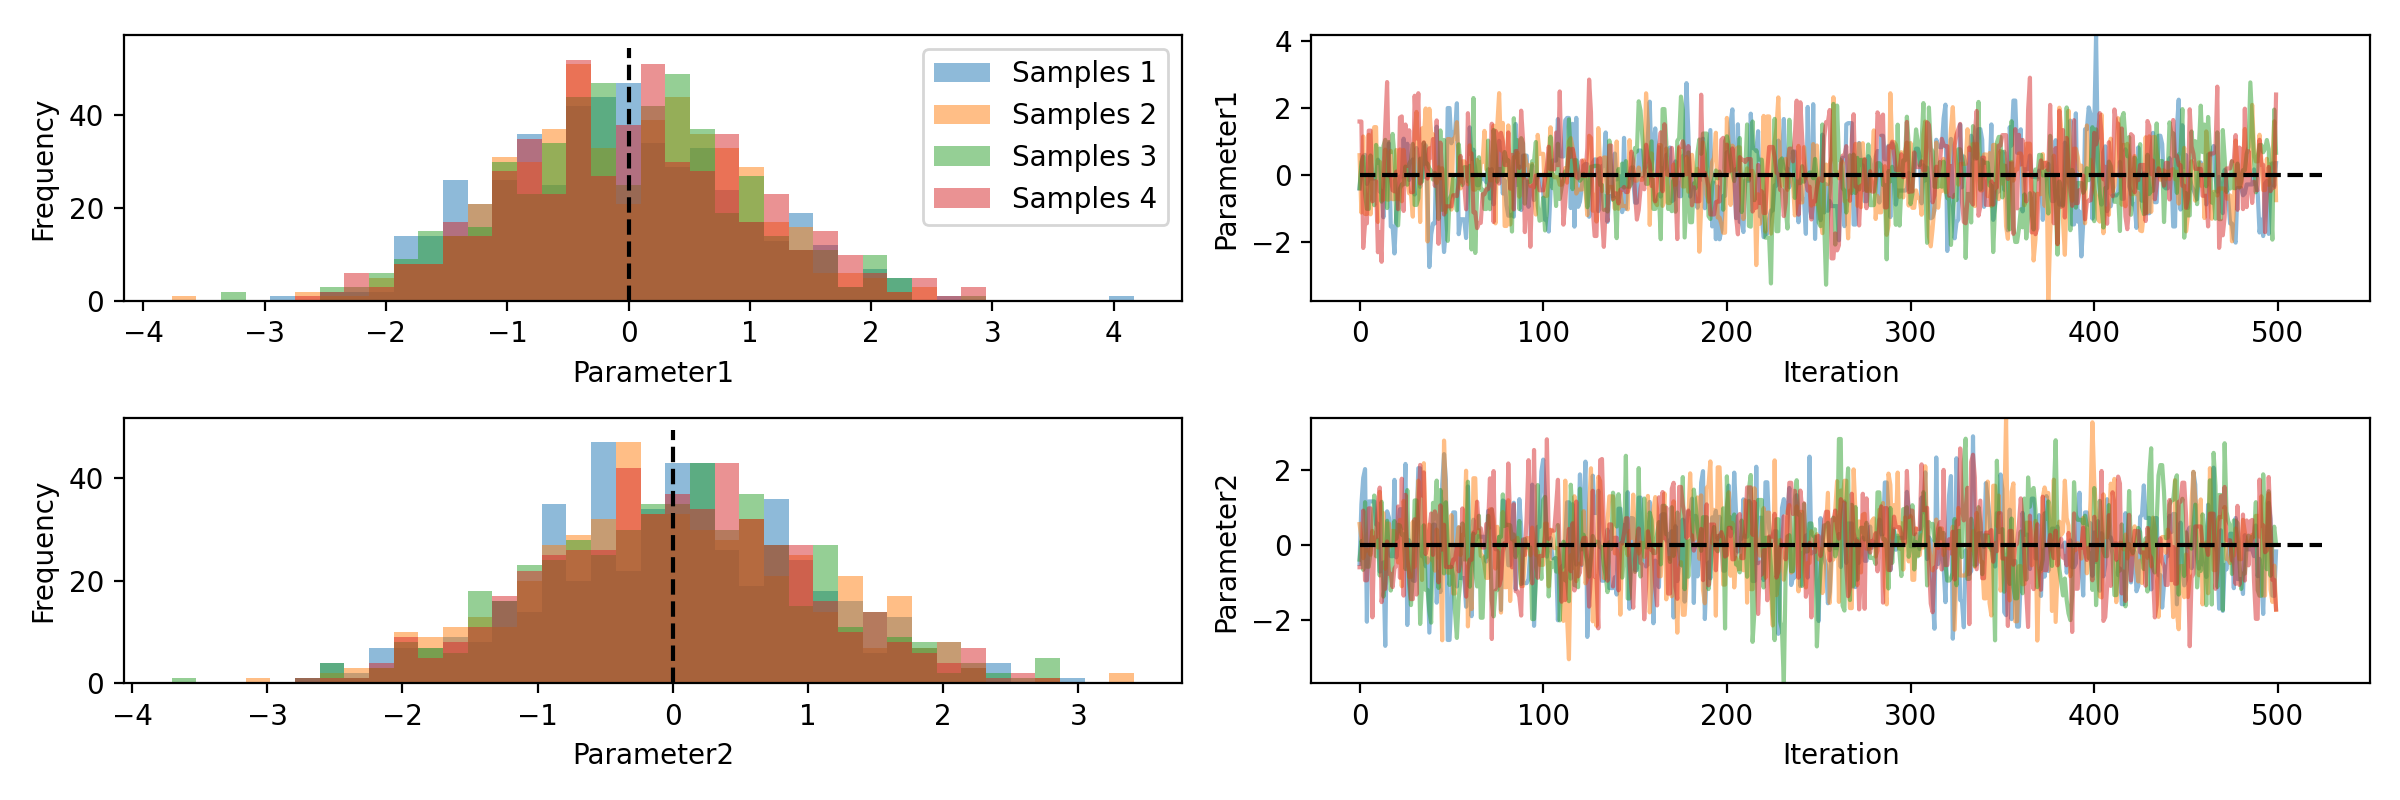

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.04   0.99    -1.90   -0.73  -0.06  0.63   1.95     1.00    563.37  652.25
param 2  0.01    1.02    -2.02   -0.67  0.02   0.69   2.01     1.00    609.20  705.31


In [4]:
n_chains = 4
n_iterations = 1000
n_warmup = 500
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(True)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

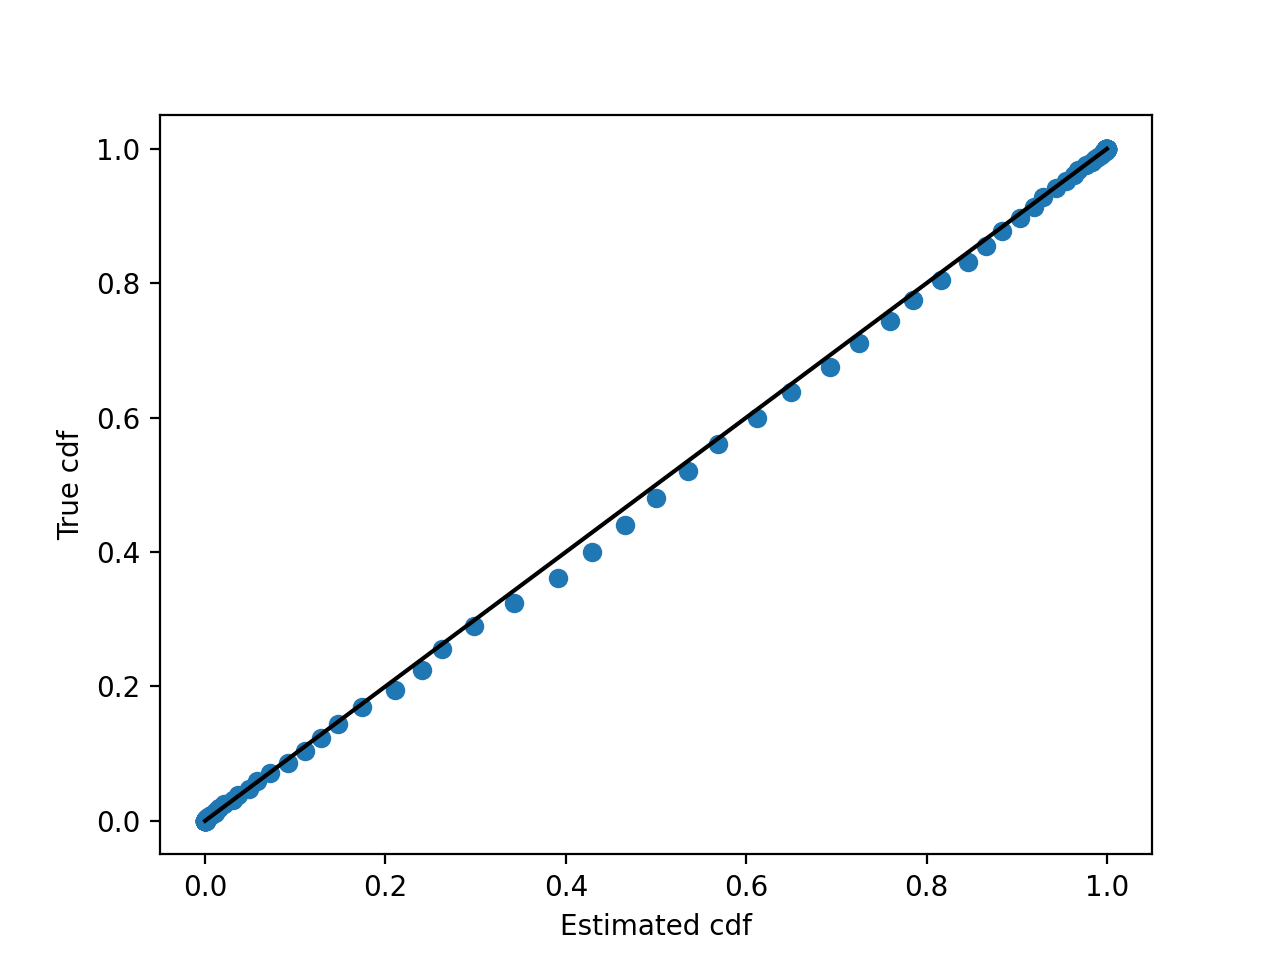

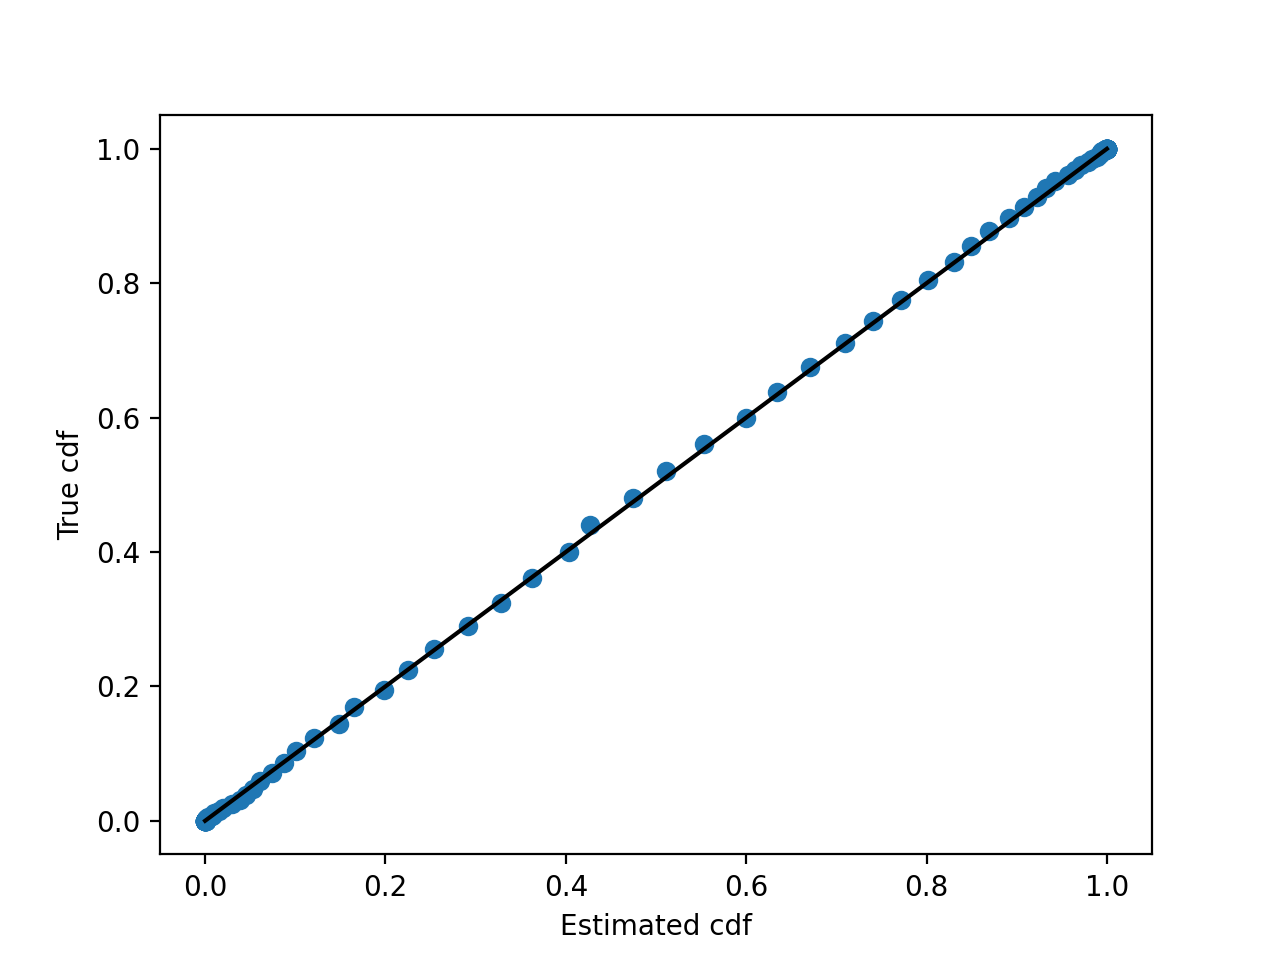

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.correlated_gaussian, parallel)
print(t.format())
df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_correlated_gaussian.csv")

1 minute, 31 seconds


/Users/ioaros/opt/anaconda3/envs/pints/lib/python3.8/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


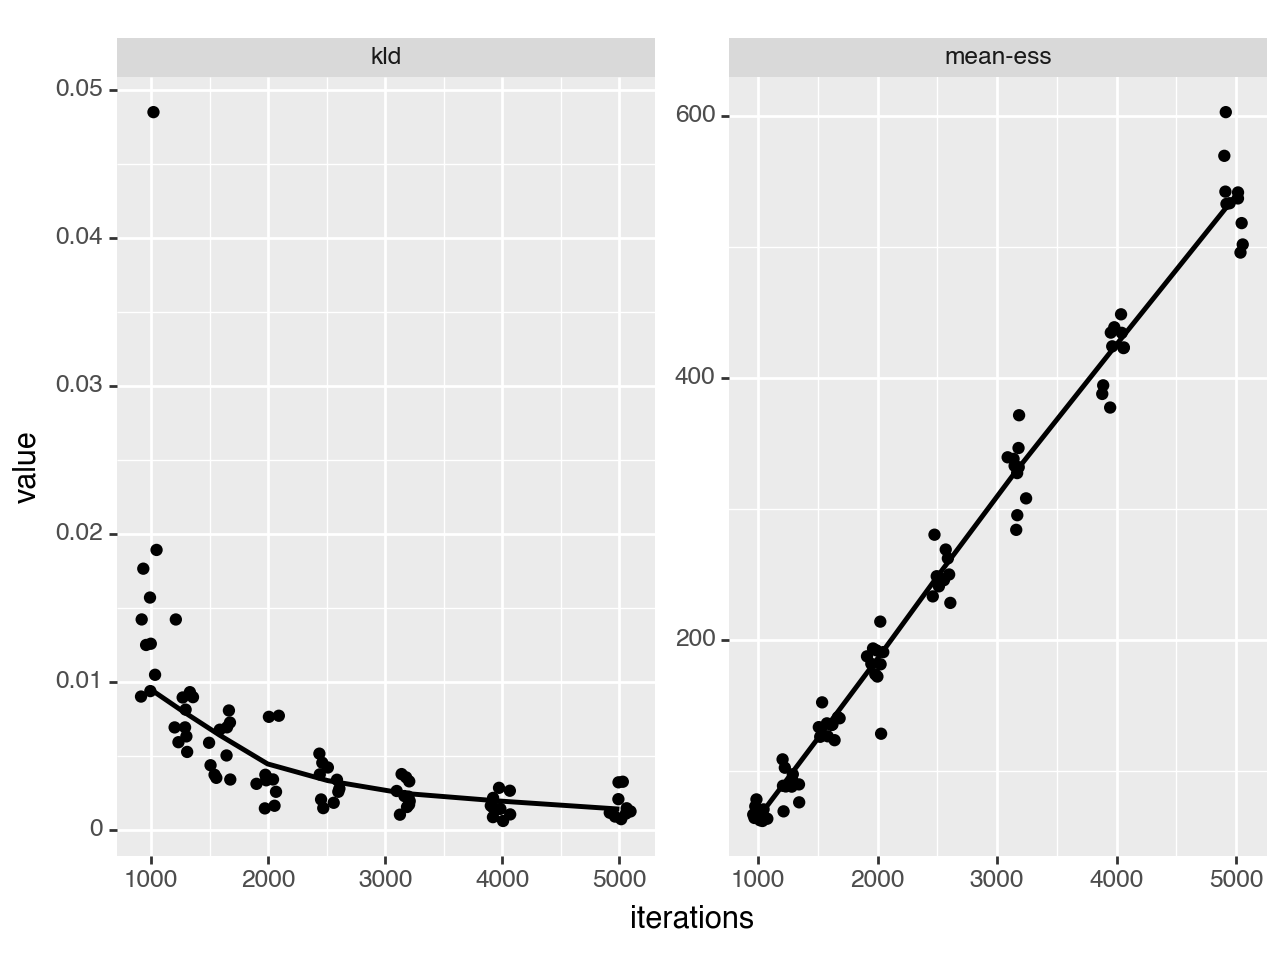

<Figure Size: (640 x 480)>

In [7]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Example run of results.

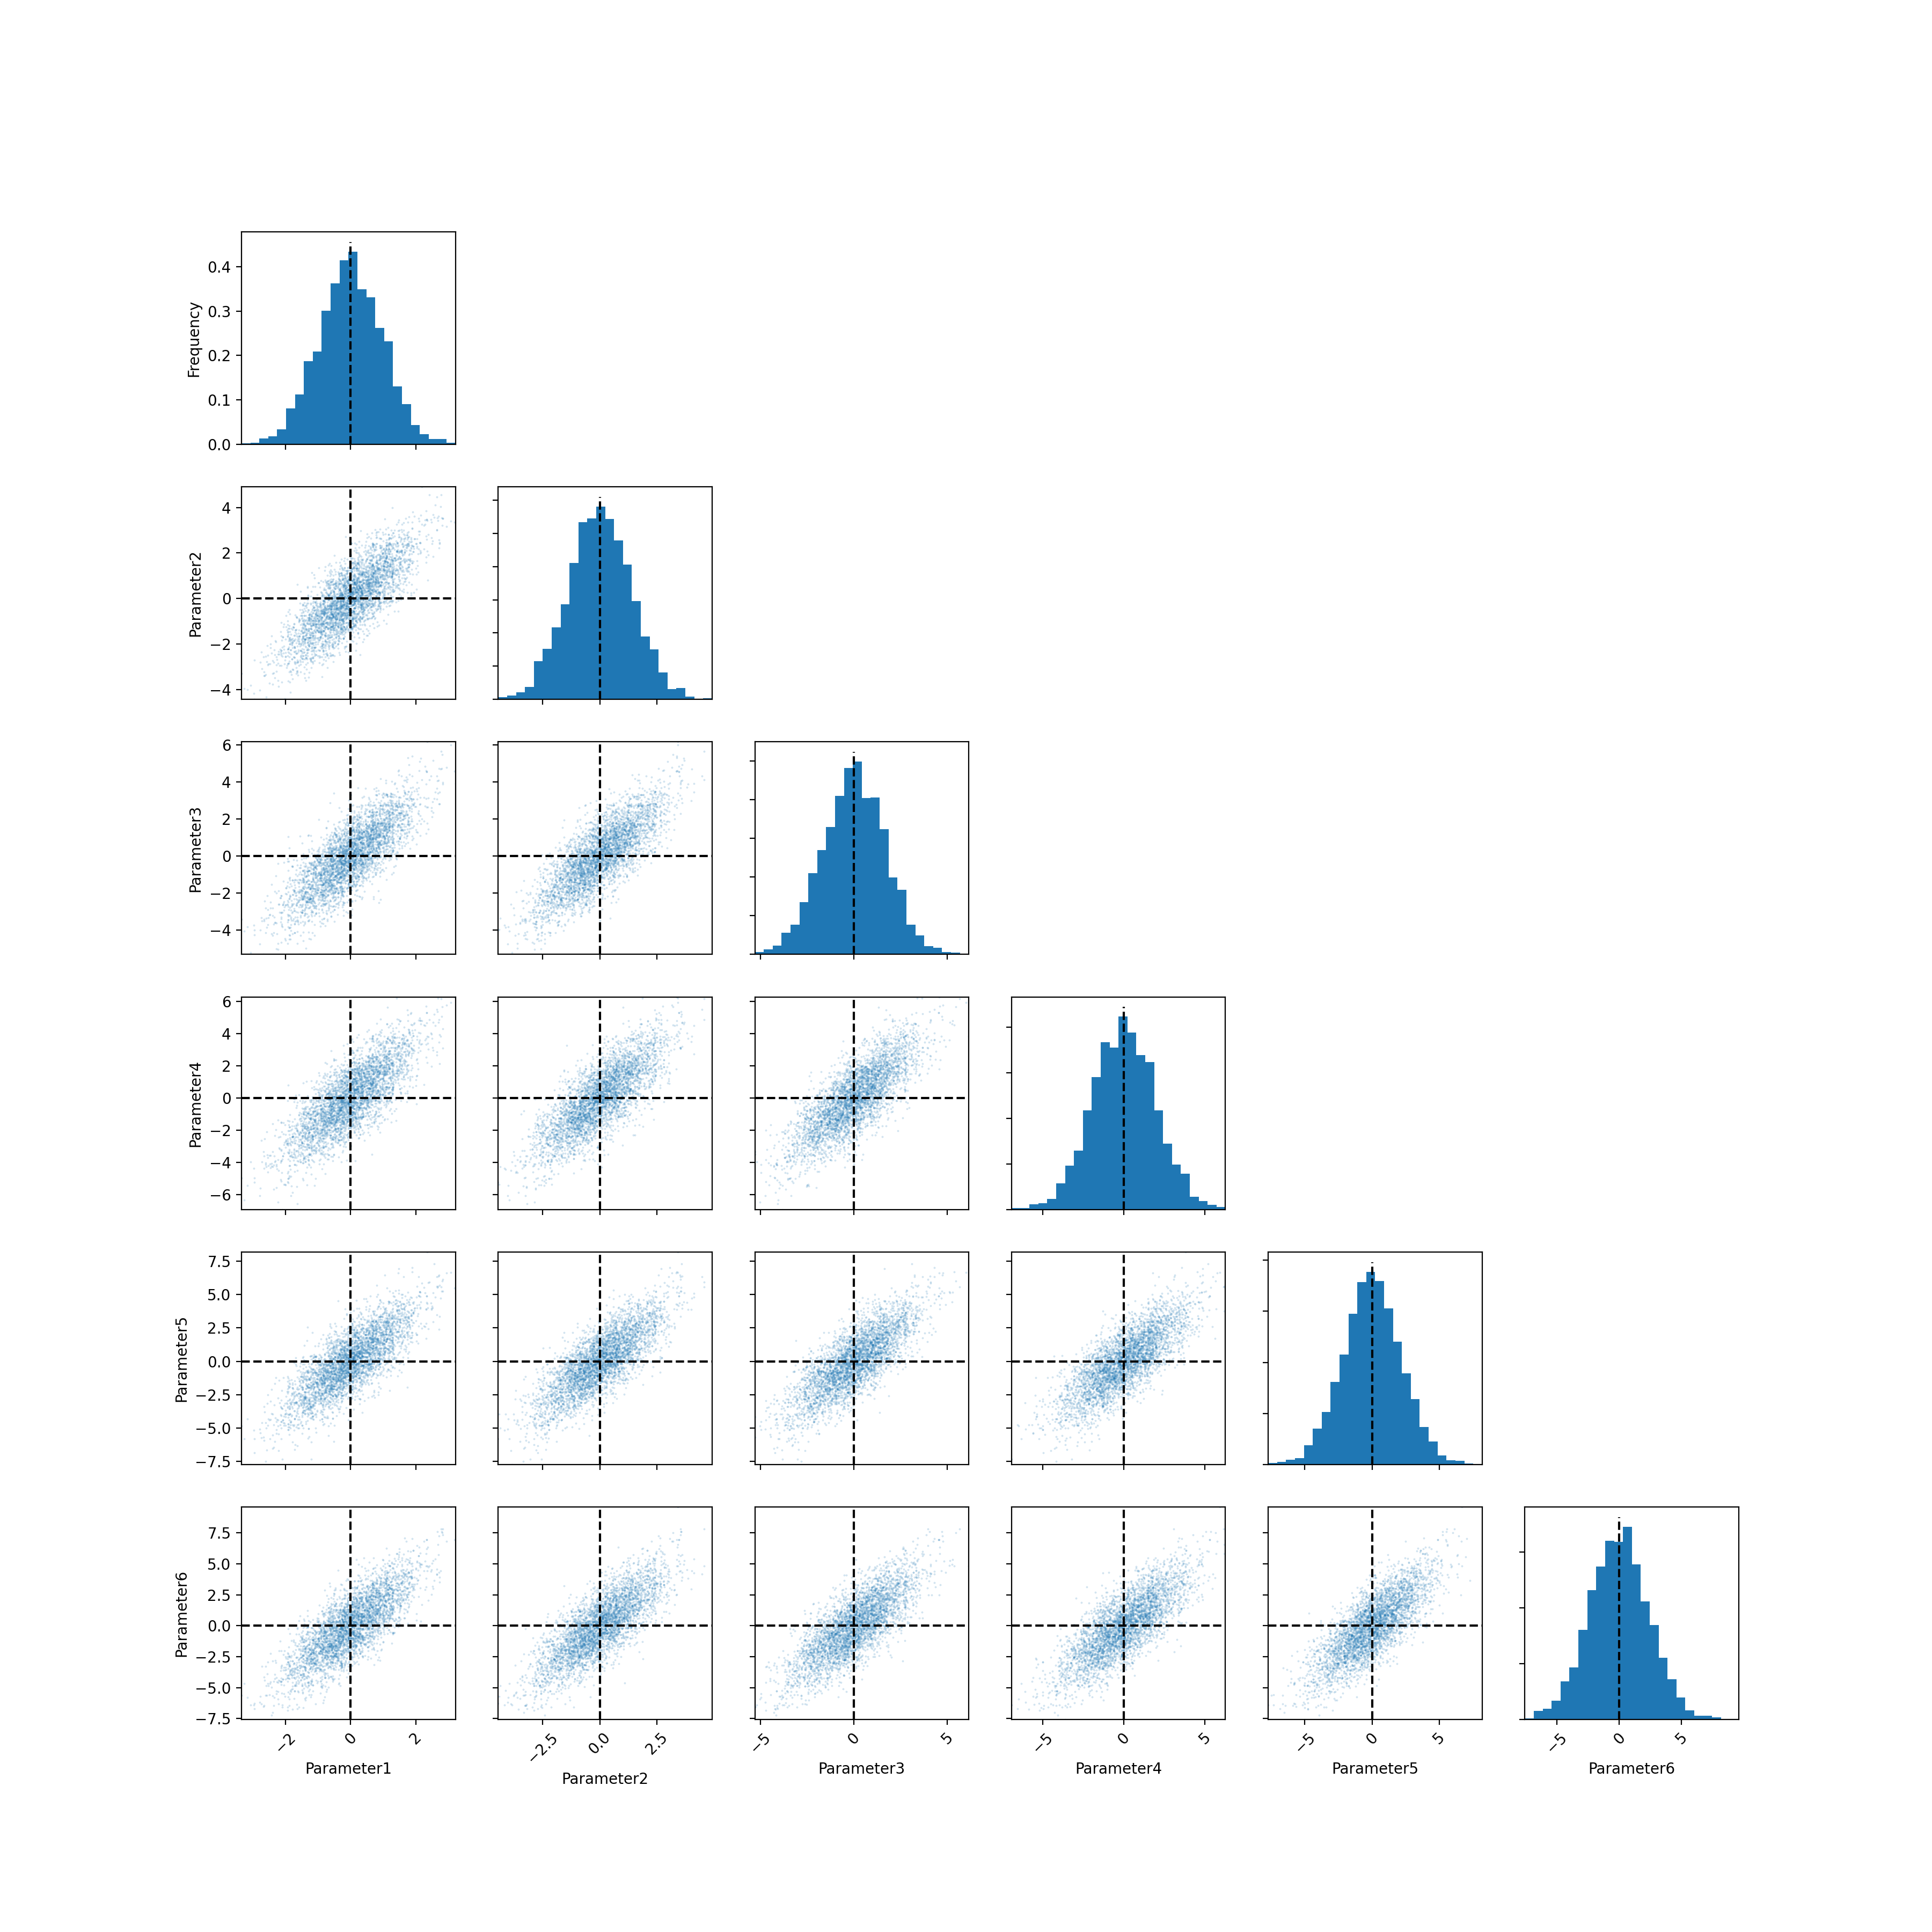

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.01   0.97    -1.90   -0.65  -0.01  0.66   1.85     1.00    498.28  120.25
param 2  0.00    1.38    -2.67   -0.91  -0.01  0.93   2.67     1.00    510.48  123.19
param 3  0.01    1.68    -3.31   -1.10  0.03   1.14   3.25     1.00    527.19  127.22
param 4  0.00    1.95    -3.82   -1.32  -0.00  1.35   3.80     1.00    508.86  122.80
param 5  -0.01   2.18    -4.35   -1.41  -0.02  1.45   4.31     1.00    516.42  124.62
param 6  -0.02   2.39    -4.70   -1.64  -0.01  1.57   4.66     1.00    516.48  124.64


In [8]:
n_chains = 4
n_iterations = 2000
n_warmup = 1000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

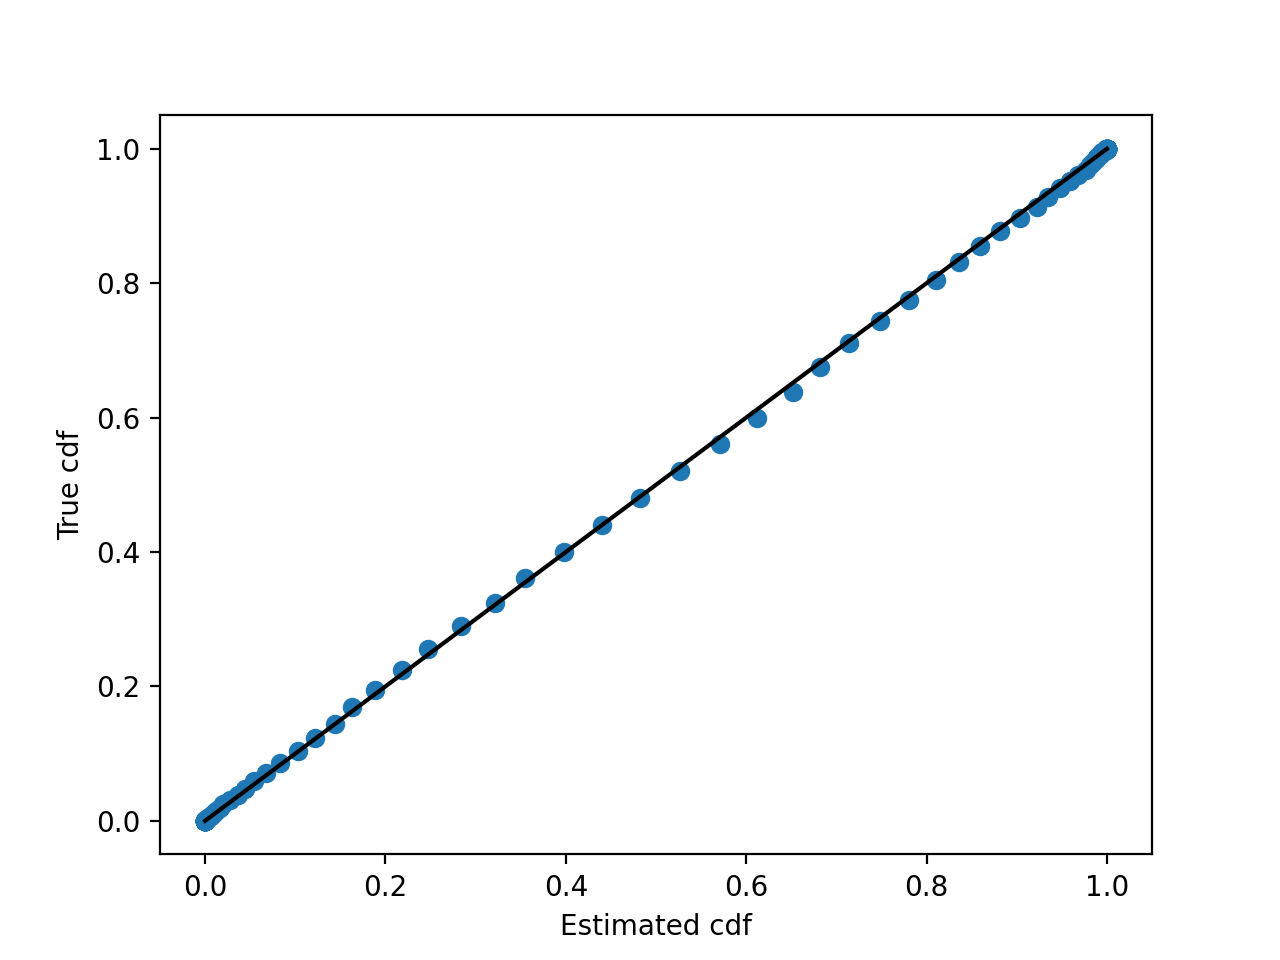

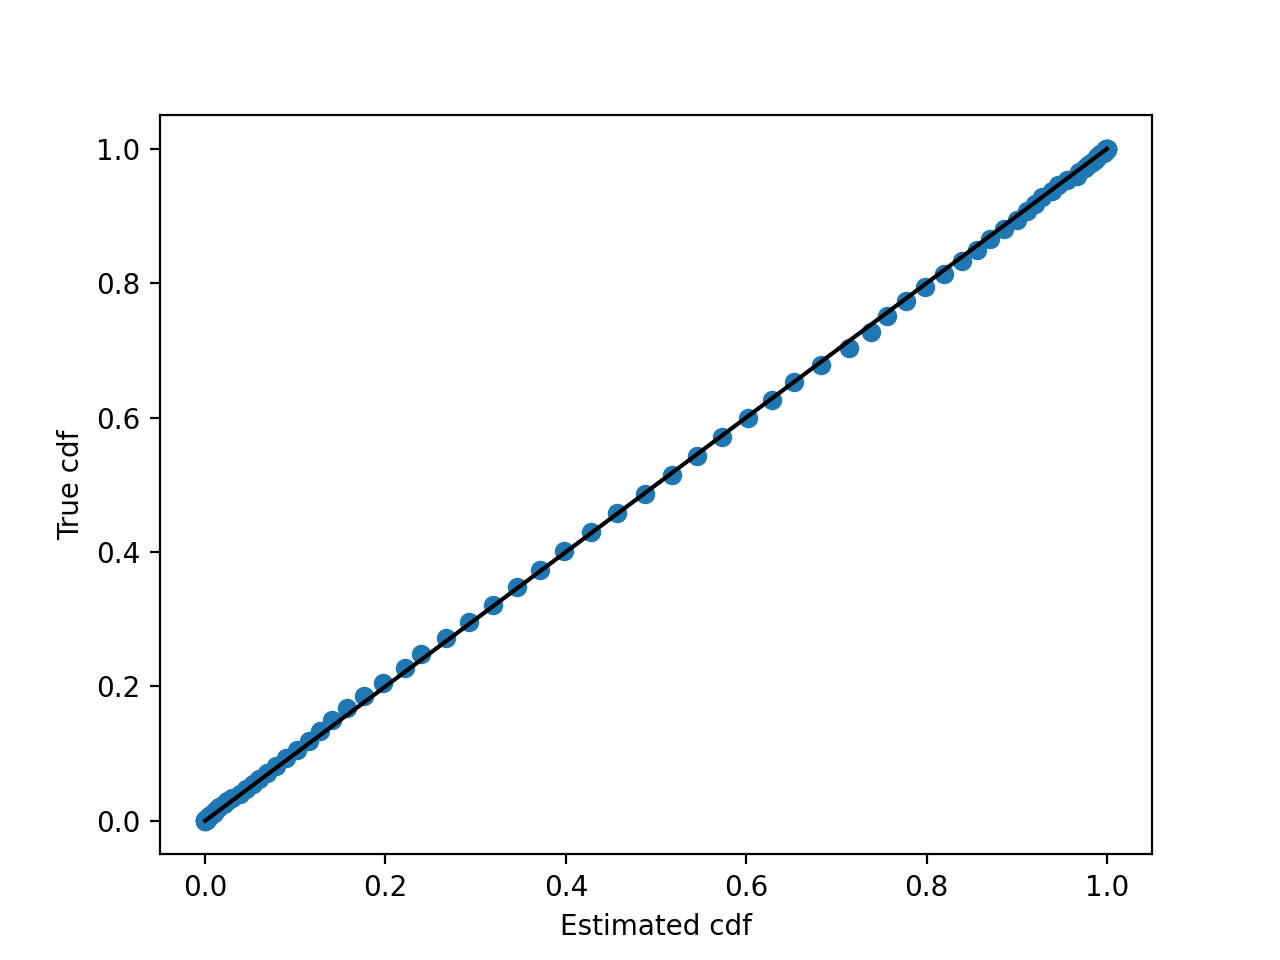

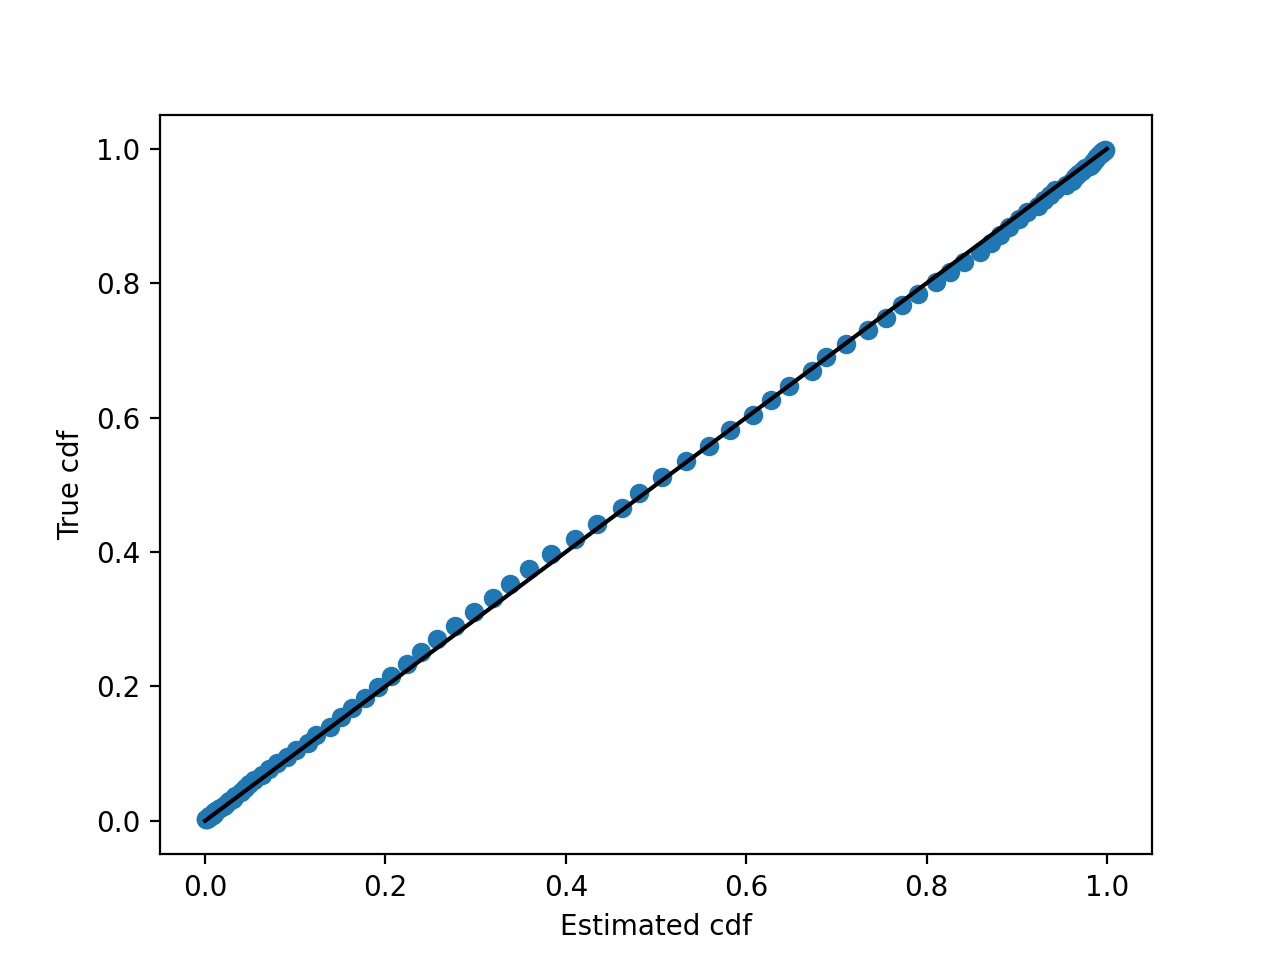

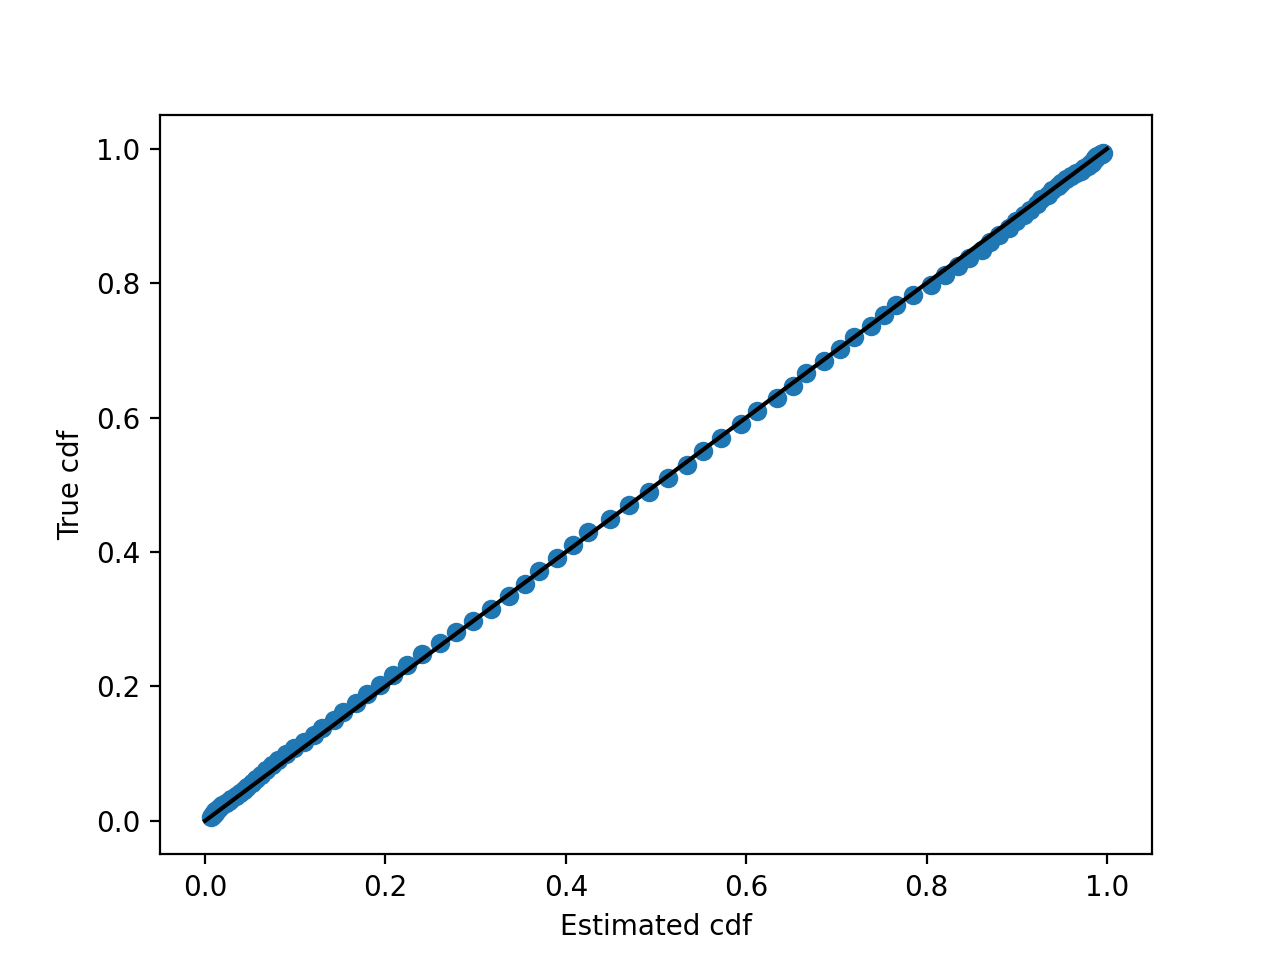

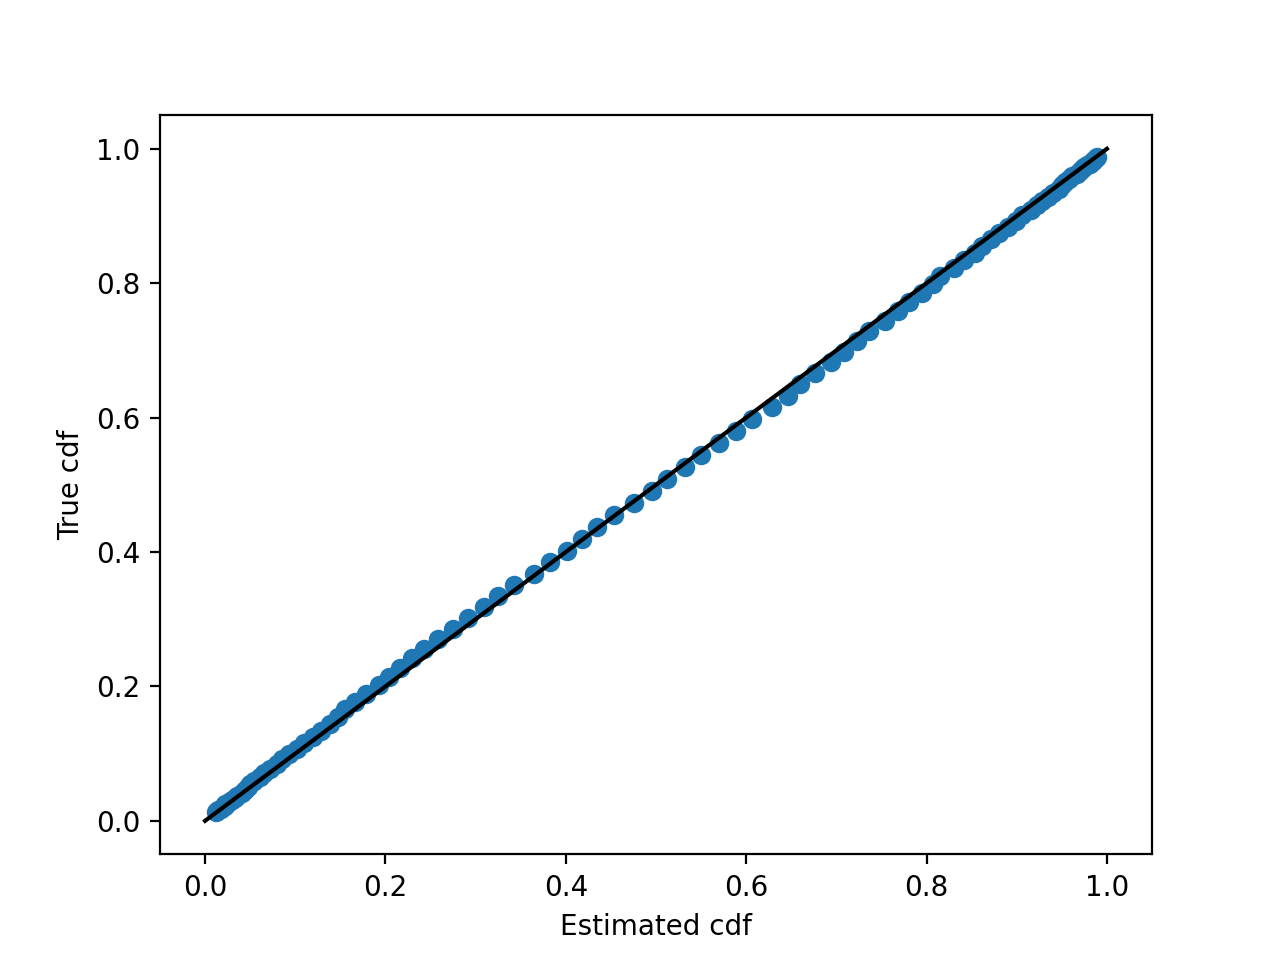

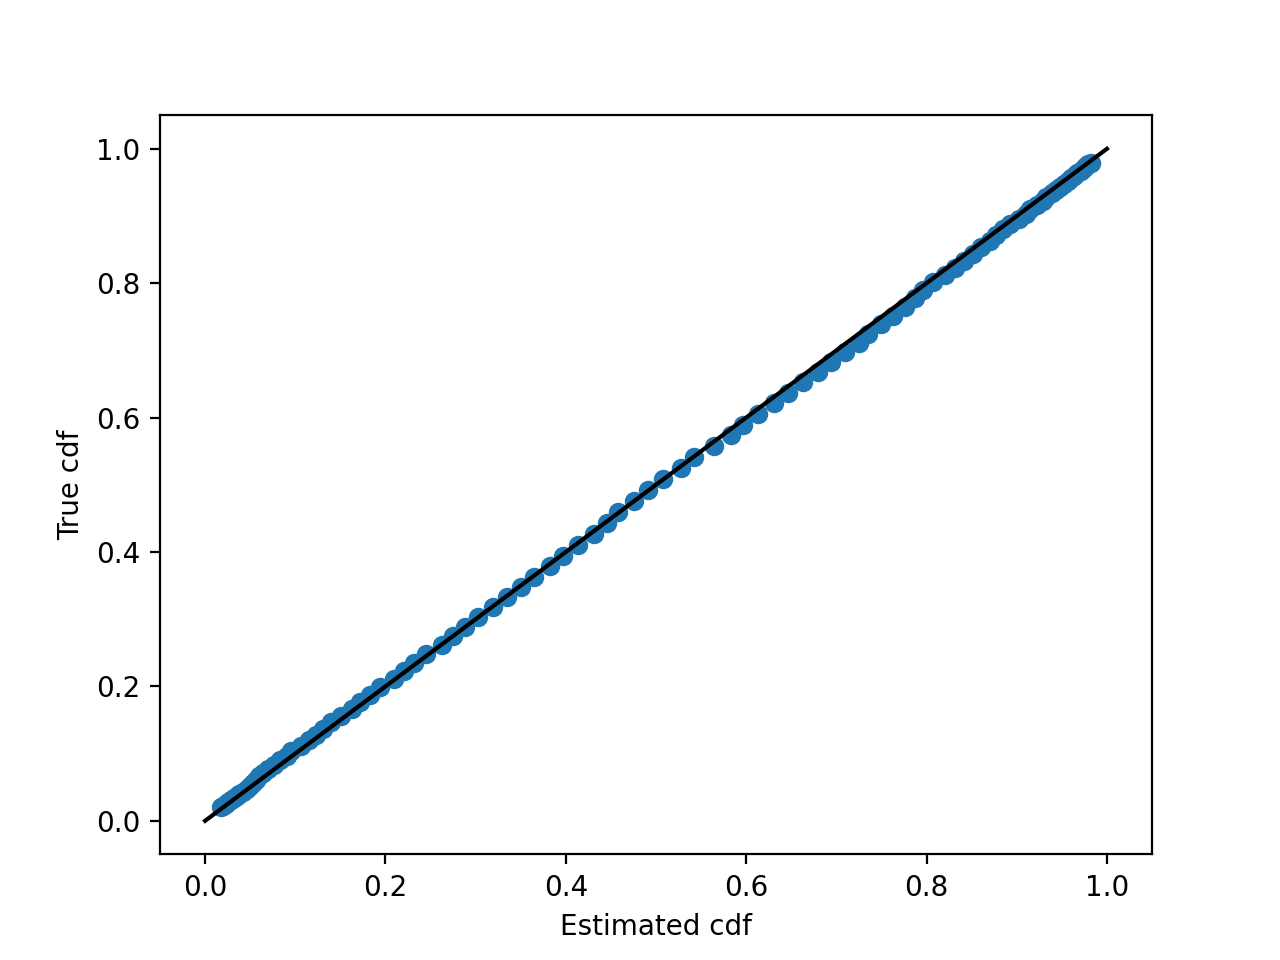

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Annulus

In [13]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.annulus, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_annulus.csv")

8 minutes, 14 seconds


/Users/ioaros/opt/anaconda3/envs/pints/lib/python3.8/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


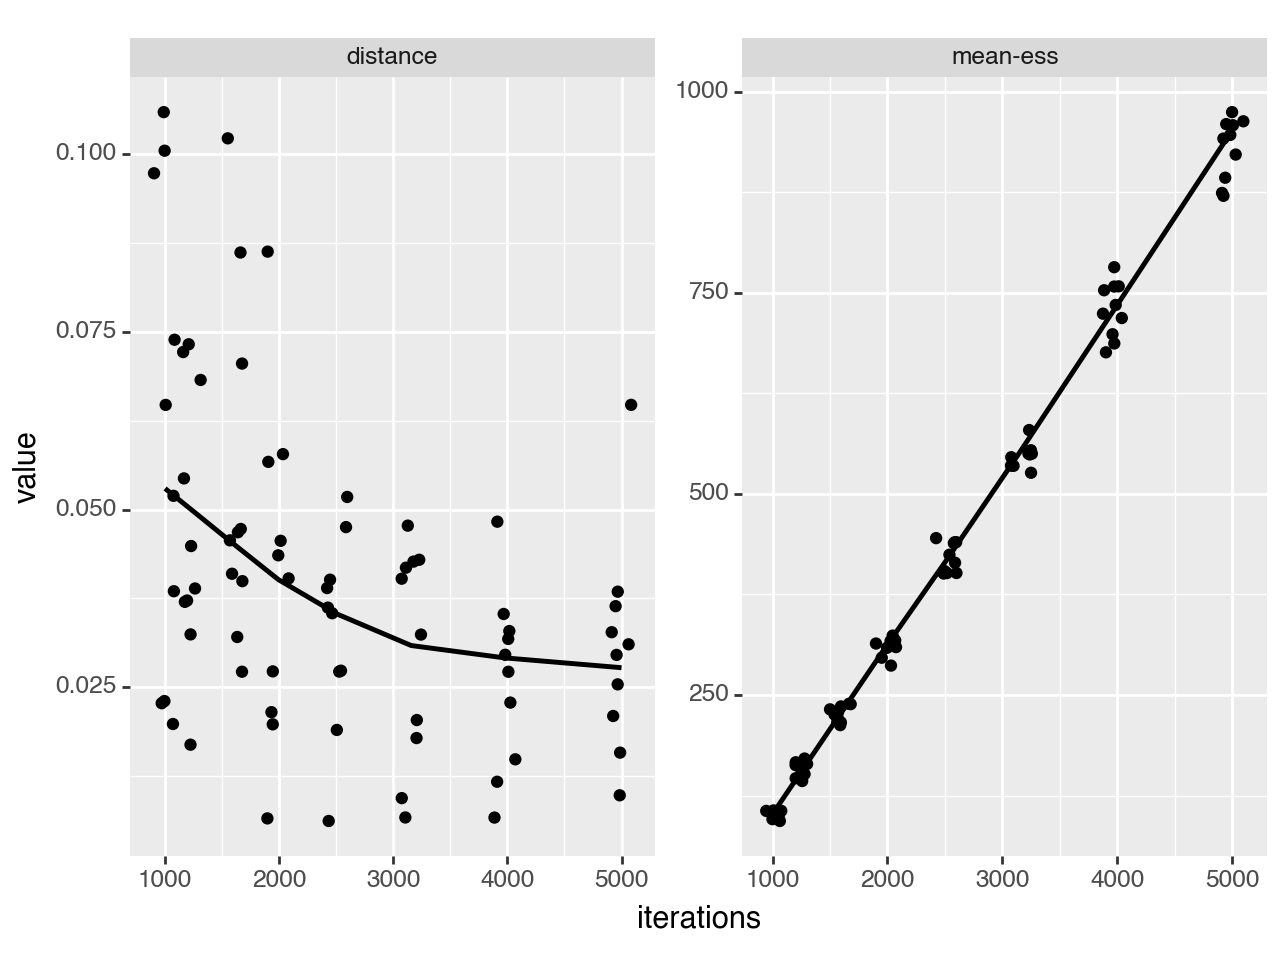

<Figure Size: (640 x 480)>

In [14]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The draws trend closer to convergence as the number of iterations increases, although the effective sample size is low here.

Example run.

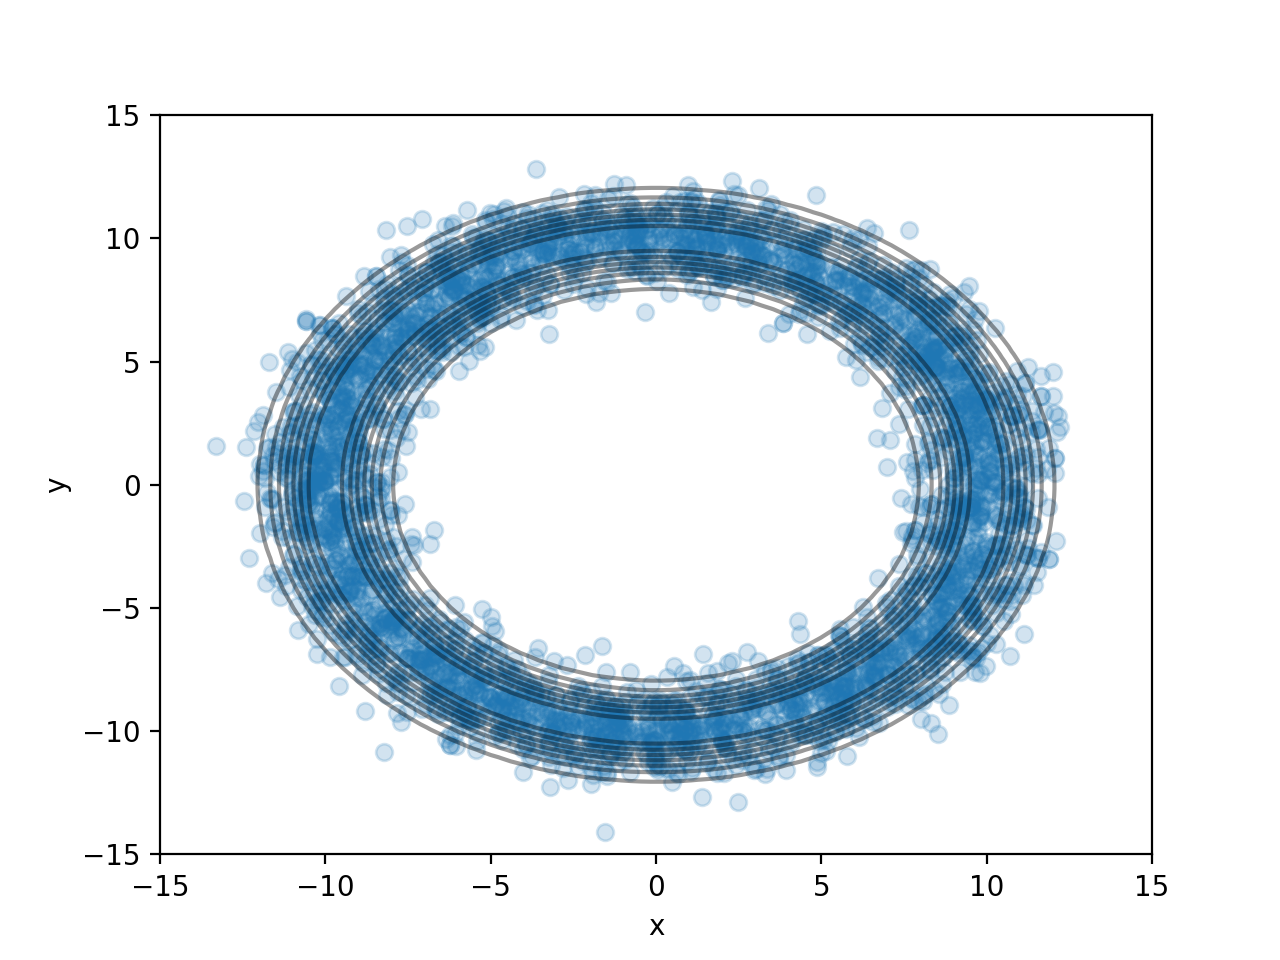

In [15]:
n_chains = 4
n_iterations = 2000
n_warmup = 1000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# High dimensional Gaussian

In [16]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.high_dim_gaussian, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_high_dim_gaussian.csv")

2 minutes, 2 seconds


/Users/ioaros/opt/anaconda3/envs/pints/lib/python3.8/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


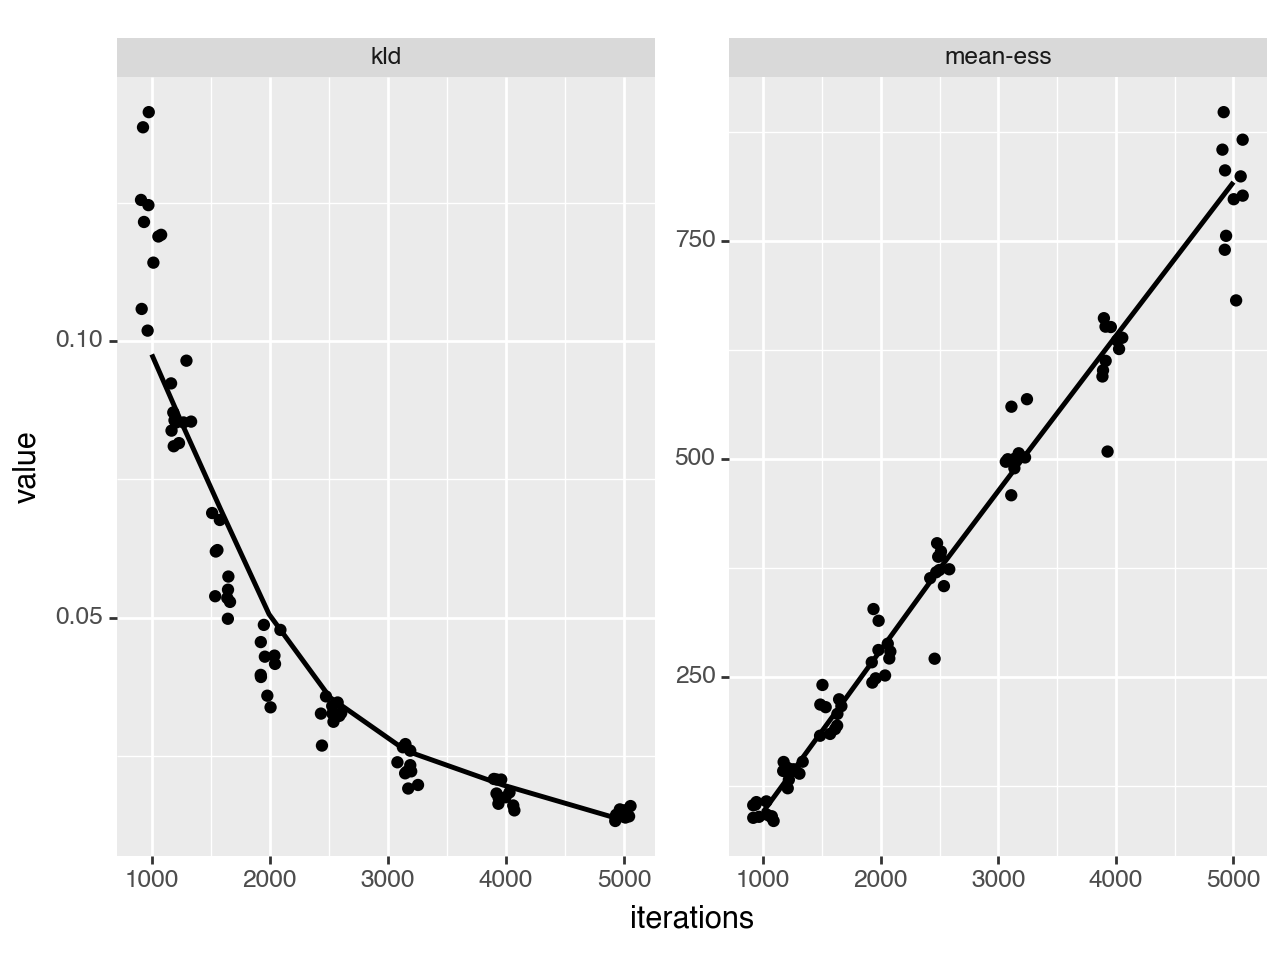

<Figure Size: (640 x 480)>

In [17]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Example run of results.

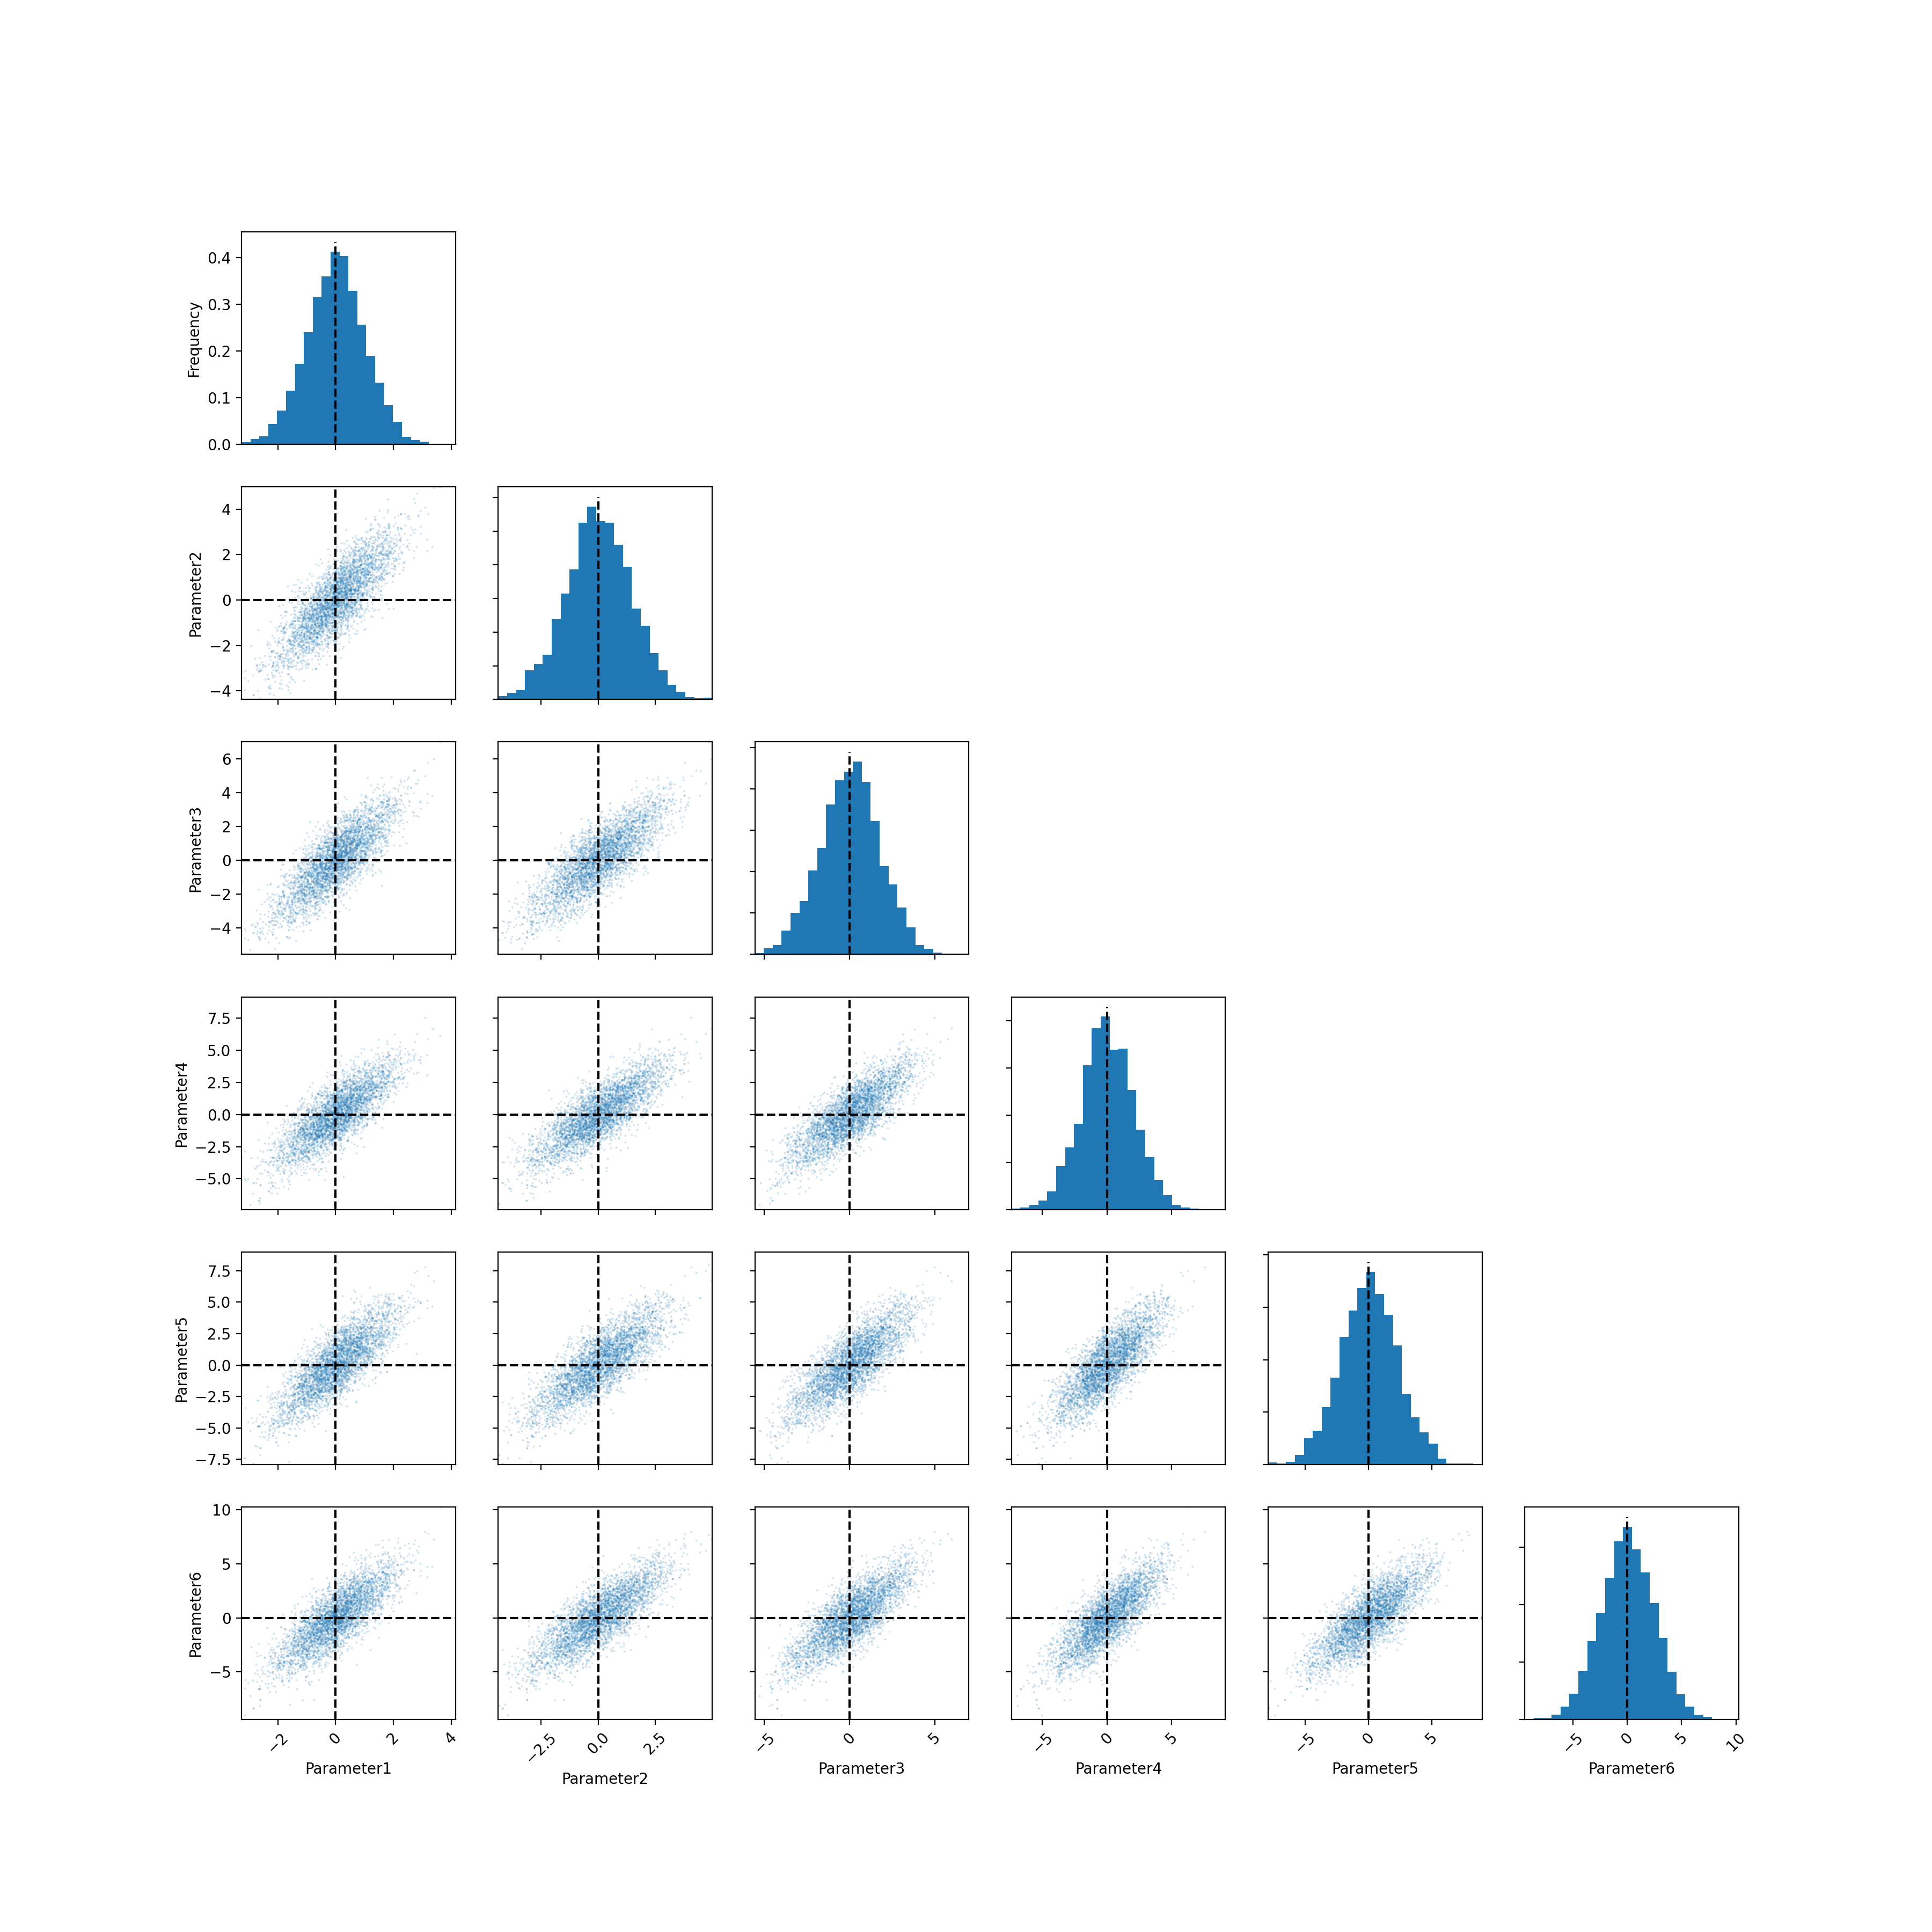

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.02    1.01    -2.00   -0.65  0.03   0.69   2.00     1.01    539.87  129.93
param 2  0.02    1.43    -2.87   -0.92  0.01   0.99   2.76     1.01    519.03  124.91
param 3  0.04    1.75    -3.49   -1.11  0.09   1.20   3.42     1.01    526.94  126.82
param 4  0.03    2.04    -3.94   -1.30  -0.02  1.39   4.00     1.01    549.29  132.20
param 5  0.07    2.26    -4.48   -1.44  0.06   1.59   4.60     1.01    538.10  129.50
param 6  0.03    2.48    -4.78   -1.62  0.01   1.70   4.91     1.01    536.76  129.18


In [18]:
n_chains = 4
n_iterations = 2000
n_warmup = 1000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

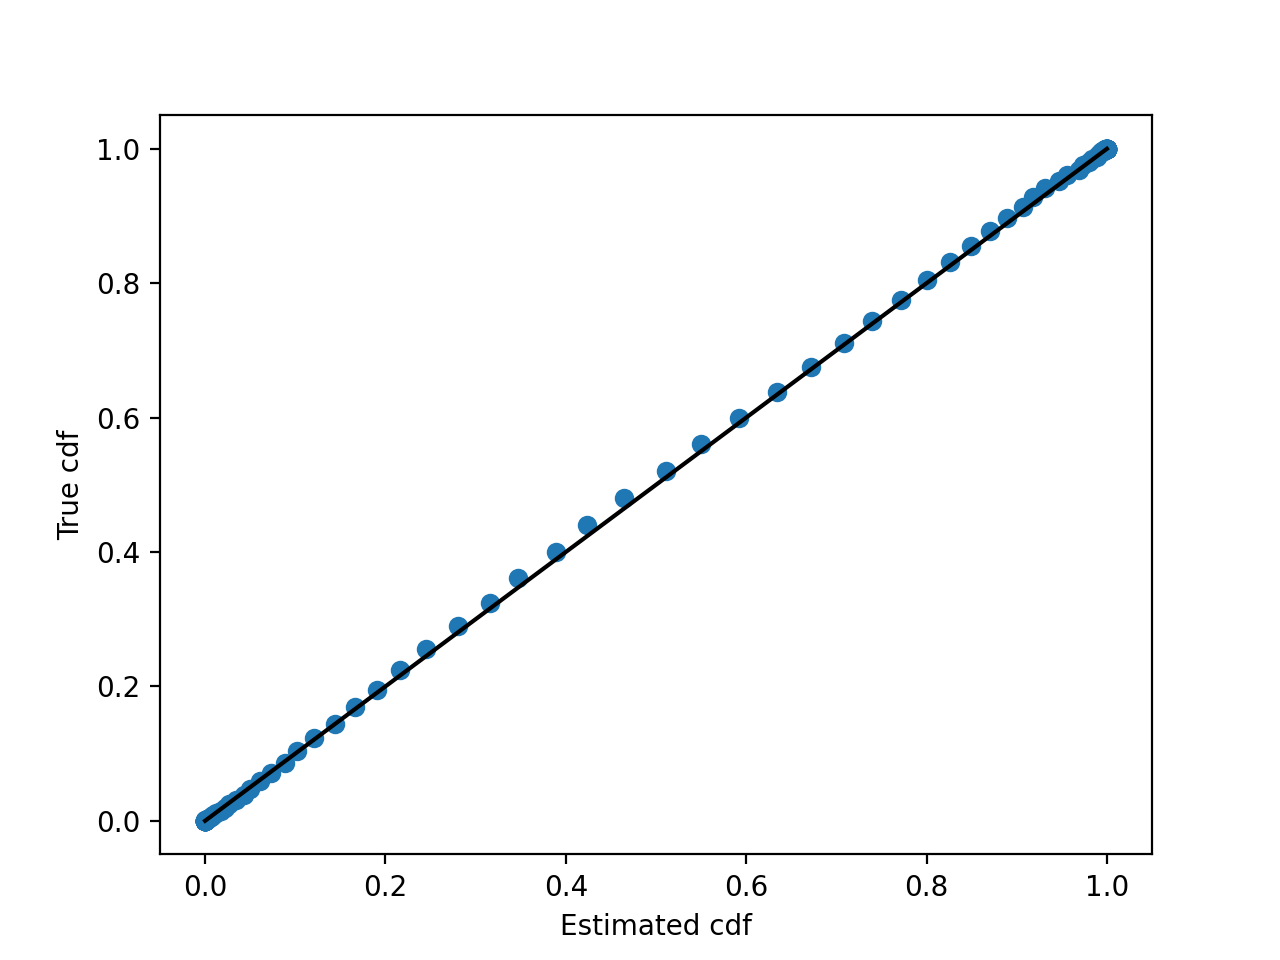

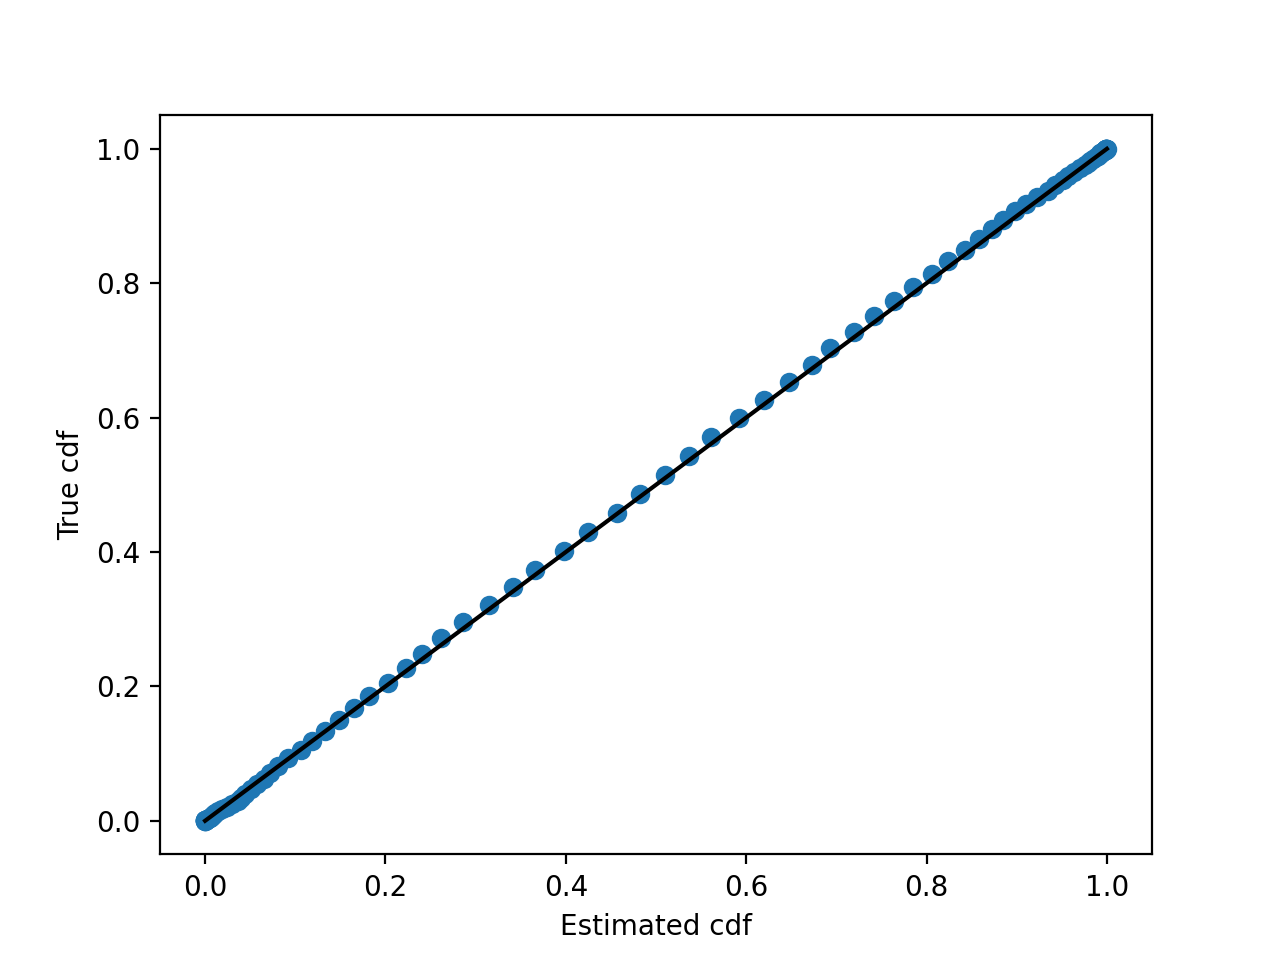

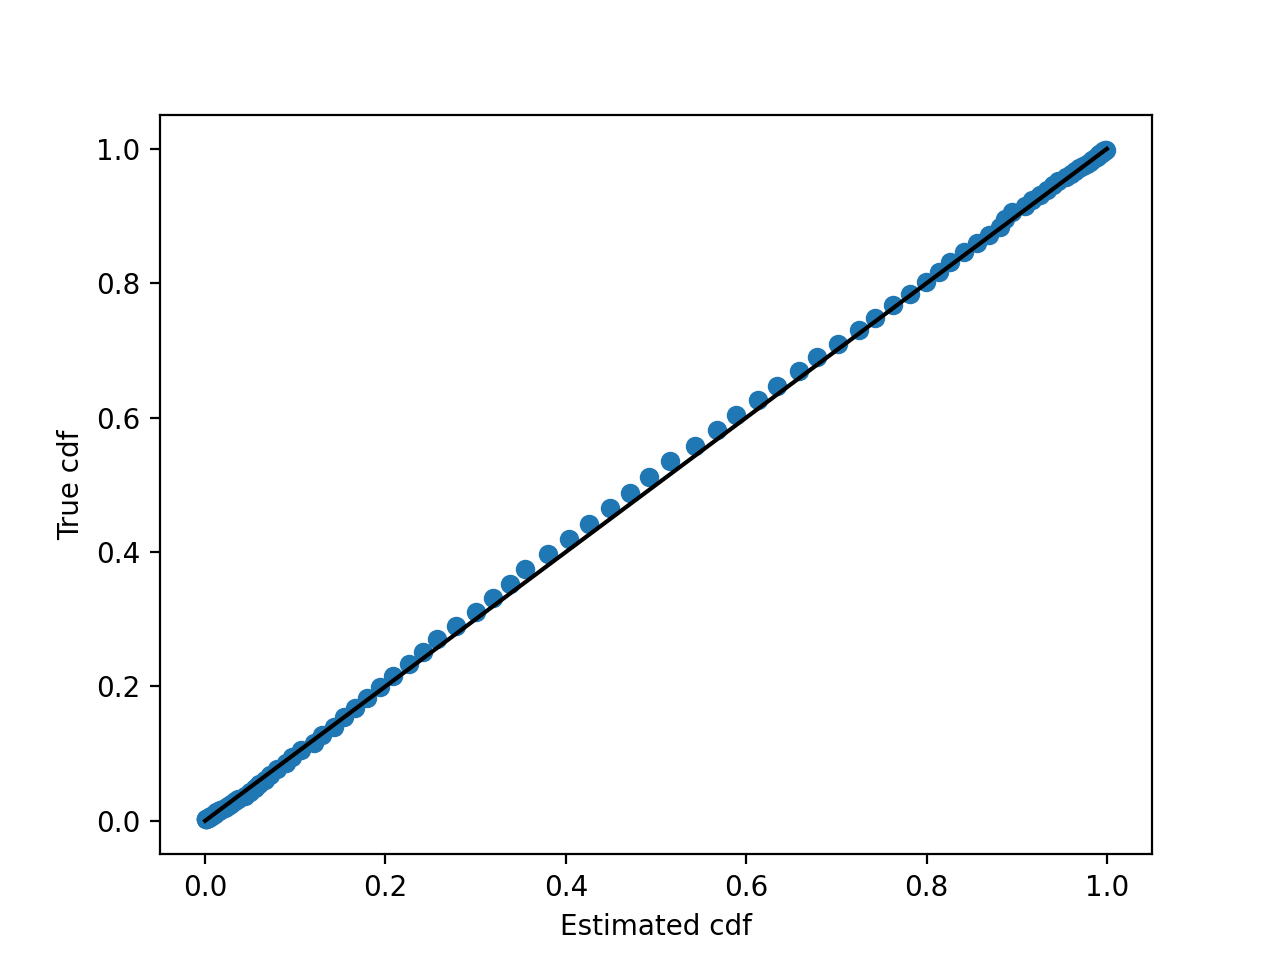

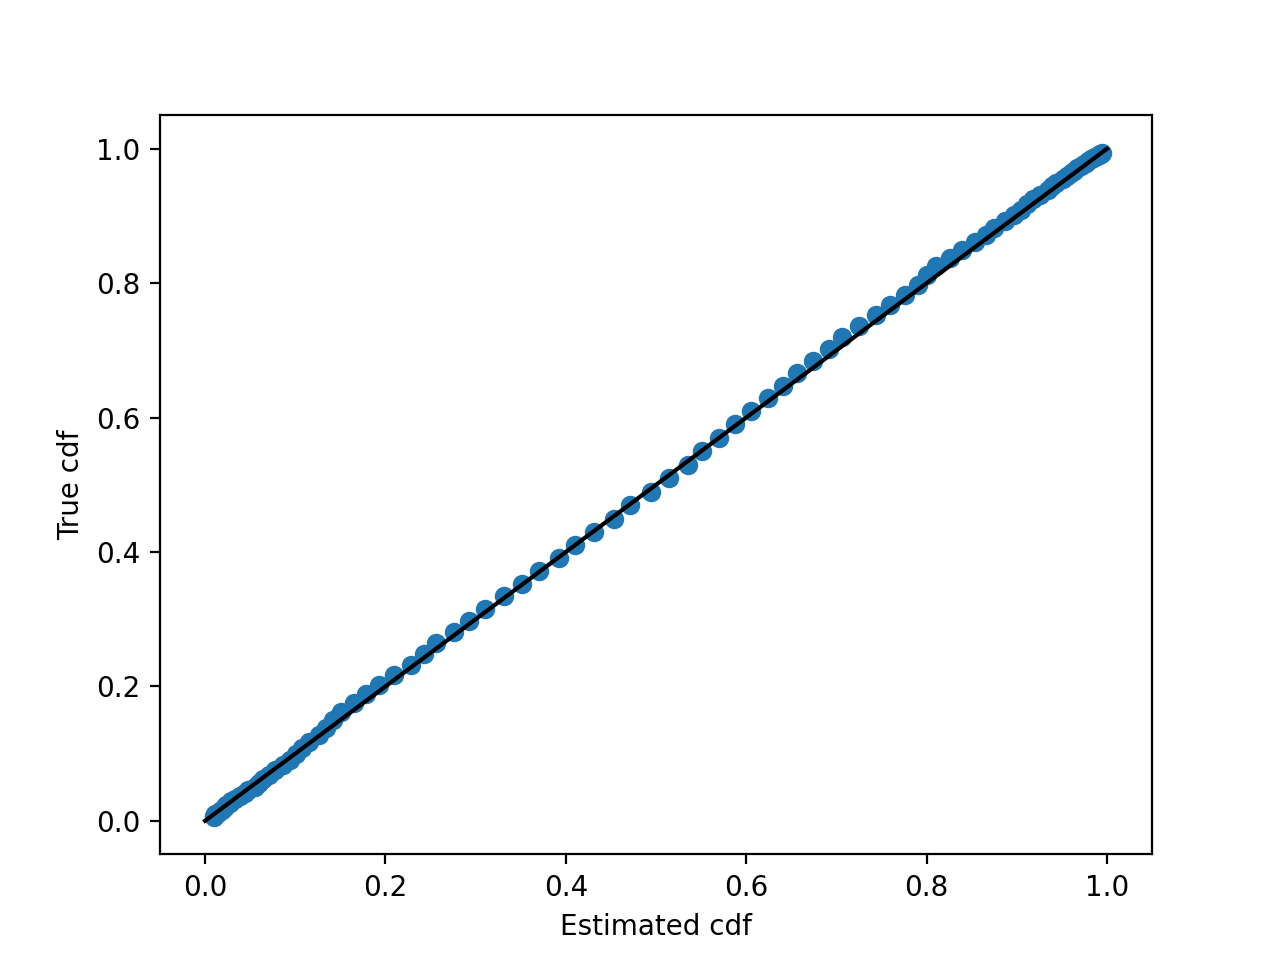

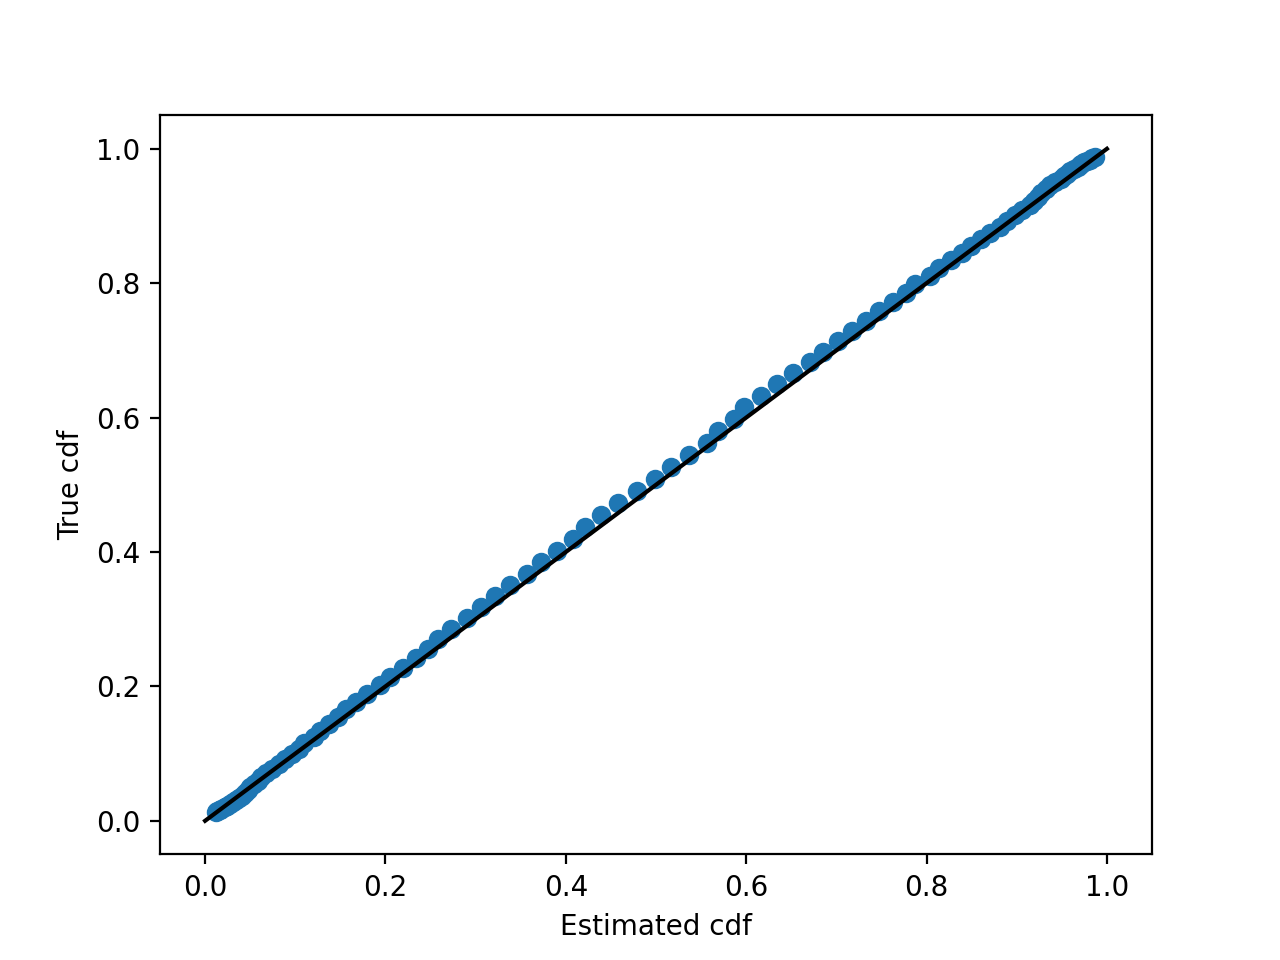

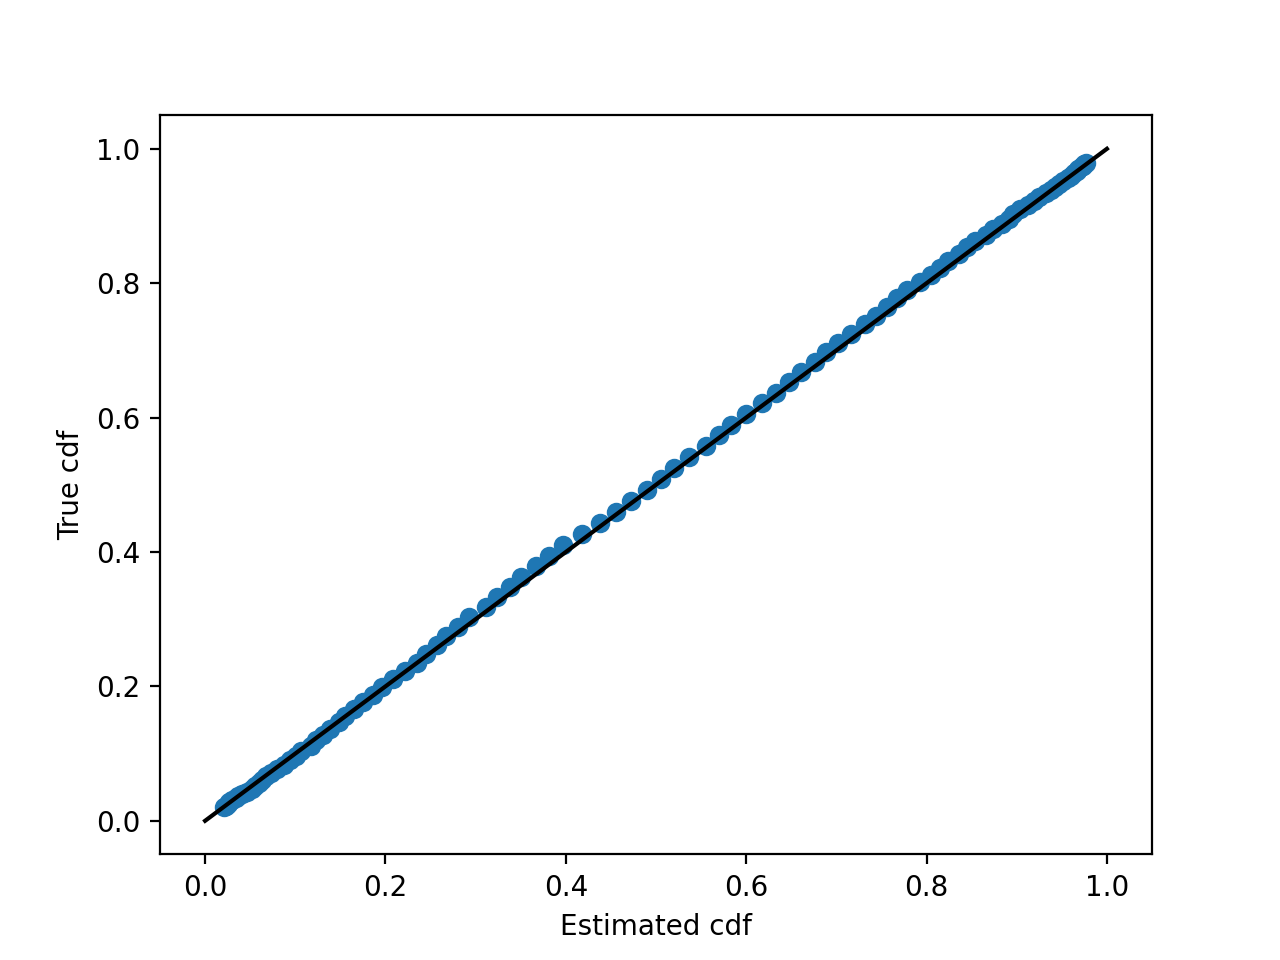

[None, None, None, None, None, None]

In [19]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]